# 20 - 即插即用估计器

到目前为止，我们已经讨论了在处理不是随机分配的情况下如何校正数据，这种情况会引入混杂偏差。这有助于解决因果推断中的识别问题。换句话说，一旦单位是可交换的，或者满足 $ Y(0), Y(1) \perp X$ 的条件，我们就可以识别处理效应。但这还远未结束。

识别意味着我们能够得到平均处理效应。也就是说，我们知道某个处理在平均意义下的效果。这固然有用，可以帮助我们决定是否推出某项处理。但我们想要的不止于此，我们希望知道是否存在对处理反应更好或更差的亚群体，以便只对那些能够受益的个体实施处理，从而制定更优的政策。

## 问题设定

让我们回顾感兴趣的设定。根据潜在结果，我们可以定义个体处理效应为两个潜在结果之差：

$
\tau_i = Y_i(1) − Y_i(0),
$

对于连续处理的情况，定义 $ \tau_i = \partial Y(t)$，其中 $t$ 为处理变量。当然，我们永远无法观察到个体处理效应，因为我们只能看到潜在结果中的一个：

$$
Y^{obs}_i(t)=
\begin{cases}
Y_i(1), & \text{if } t=1\\
Y_i(0), & \text{if } t=0
\end{cases}
$$

平均处理效应（ATE）定义为

$
\tau = E[Y_i(1) − Y_i(0)] = E[\tau_i]
$

条件平均处理效应（CATE）定义为

$
\tau(x) = E[Y_i(1) − Y_i(0)|X] = E[\tau_i|X]
$

在本书的第一部分，我们主要关注 ATE。现在我们关注的是 CATE。CATE 对于个性化决策非常有用。例如，如果某种药物是我们的处理 $t$，我们想知道哪类患者对该药物反应更敏感（较高的 CATE），以及是否存在某些患者的反应为负（CATE < 0）。

我们已经看到如何通过在线性回归模型中加入处理与特征之间的交互项来估计 CATE：

$
y_i = \beta_0 + \beta_1 t_i + \beta_2 X_i + \beta_3 t_i X_i + e_i.
$

如果估计该模型，我们可以得到 $\tau(x)$ 的估计：

$
\hat{\tau}(x) = \hat{\beta}_1 + \hat{\beta}_3 X_i
$

然而，线性模型仍然有一些缺陷，主要是对特征 $X$ 做出线性假设。注意在这个模型中 $\beta_2$ 并不重要。但如果特征 $X$ 与结果之间的关系不是线性的，那么因果参数 $\beta_1$ 和 $\beta_3$ 的估计将会偏离真实值。

如果我们能用更灵活的机器学习模型替代线性模型就好了。我们甚至可以将处理作为特征输入到机器学习模型，例如提升树或神经网络：

$
y_i = M(X_i, T_i) + e_i
$

但是从这种模型中我们无法直接得到处理效应的估计，因为该模型输出的是 $\hat{y}$ 的预测，而不是 $\hat{\tau(x)}$ 的预测。理想情况下，我们希望使用一种机器学习回归模型，它不是最小化结果的均方误差 (MSE)：

$
E[(Y_i - \hat{Y}_i)^2]
$

而是最小化处理效应的均方误差：

$
E[(\tau(x)_i - \hat{\tau}(x)_i)^2] = E[(Y_i(1) - Y_i(0) - \hat{\tau}(x)_i)^2].
$

然而，这样的目标函数是不可行的。问题在于 $\tau(x)_i$ 是不可观测的，因此我们无法直接针对它优化。这让我们陷入了困境……让我们尝试简化问题，也许能想到一些办法。

![img](./images/20/infeasible.png)


## 目标变换

假设我们的处理是二元的。例如，你是一家投资公司，正在测试发送金融教育邮件的效果。你希望邮件能使人们投资更多。假设你开展了一项随机实验，50% 的客户收到了邮件，另 50% 的客户没有收到。

下面有一个大胆的想法：通过处理变量来变换结果变量。

$
Y^*_i = 2 Y_i * T_i - 2 Y_i*(1-T_i)
$

因此，如果某个个体接受了处理，我们将其结果乘以 2；如果没有接受处理，则将结果乘以 -2。例如，某位客户投资了 2000 巴西雷亚尔并收到了邮件，变换后的目标是 4000；如果他没有收到邮件，则变换后的目标是 -4000。

这听起来有些奇怪，好像在说邮件的效果可能是负数，但请耐心看下去。通过一些数学推导我们会发现，这个变换后的目标的期望等于处理效应。这非常惊人，也就是说，通过这种看似古怪的变换，我们能够估计一些连观察都无法观察到的东西。

为了理解这一点，我们需要一些数学推导。由于随机分配，我们有 $T \perp Y(0), Y(1)$，也就是熟悉的无混淆性，这意味着 $E[T\,Y(t)] = E[T]\cdot E[Y(t)]$，即独立性的定义。

此外，我们知道

$
Y_i T_i = Y(1)_i T_i \text{ 且 }  Y_i (1-T_i) = Y(0)_i (1-T_i)
$

因为处理决定了哪个潜在结果被实现。有了这些，我们可以计算 $Y^*_i$ 的条件期望：

$
\begin{align}
E[Y^*_i|X_i=x] &= E[2 Y(1)_i * T_i - 2 Y(0)_i*(1-T_i)|X_i=x] \\
&= 2E[Y(1)_i * T_i | X_i=x] - 2E[Y(0)_i*(1-T_i)|X_i=x]\\
&= 2E[Y(1)_i| X_i=x] * E[ T_i | X_i=x] - 2E[Y(0)_i| X_i=x]*E[(1-T_i)|X_i=x] \\
&= 2E[Y(1)_i| X_i=x] * 0.5 - 2E[Y(0)_i| X_i=x]*0.5 \\
&= E[Y(1)_i| X_i=x] - E[Y(0)_i| X_i=x] \\
&= \tau(x)_i
\end{align}
$

因此，这个看似疯狂的想法最终产生了个体处理效应 $\tau(x)_i$ 的无偏估计。现在，我们可以用以下准则替换之前不可实现的优化准则：

$
E[(Y^*_i - \hat{\tau}(x)_i)^2] 
$

简单来说，只需用任何回归机器学习模型预测 $Y^*_i$，模型输出的就是处理效应的预测。

我们已经解决了简单的情况，那么更复杂的情况呢？例如处理分配不是五五开，甚至不是随机的？答案稍微复杂一些，但并不难。首先，如果没有随机分配，我们至少需要满足条件独立性 $T \perp Y(1), Y(0) | X$。也就是说，在控制 $X$ 后，处理可以视为随机。在这种情况下，我们将变换后的目标推广为

$
Y^*_i = Y_i * \dfrac{T_i - e(X_i)}{e(X_i)(1-e(X_i))}
$

其中 $e(X_i)$ 是倾向得分。如果处理不是 50% 的概率分配，而是按不同的概率 $p$ 随机分配，只需把上式中的倾向得分换成 $p$。如果处理并非随机分配，则必须使用倾向得分，无论是记录下来的还是估计得到的。

如果计算这个变换后的目标的期望，你会发现它同样等于处理效应。证明虽然有点繁琐，但如下所示（可以跳过）：

$
\begin{align}
E[Y^*_i|X_i=x] &= E\big[Y_i * \dfrac{T_i - e(X_i)}{e(X_i)(1-e(X_i))}|X_i=x\big] \\
&= E\big[Y_i T_i * \dfrac{T_i - e(X_i)}{e(X_i)(1-e(X_i))} + Y_i (1-T_i) * \dfrac{T_i - e(X_i)}{e(X_i)(1-e(X_i))}|X_i=x\big]\\
&= E\big[Y(1)_i * \dfrac{T_i(1 - e(X_i))}{e(X_i)(1-e(X_i))} | X_i=x\big] - E\big[Y(0)_i * \dfrac{(1-T_i)e(X_i)}{e(X_i)(1-e(X_i))}|X_i=x\big]\\
&= \dfrac{1}{e(X_i)} E[Y(1)_i * T_i|X_i=x] - \dfrac{1}{1-e(X_i)} E[Y(0)_i * (1-T_i)| X_i=x]\\
&= \dfrac{1}{e(X_i)} E[Y(1)_i|X_i=x] * E[T_i|X_i=x] - \dfrac{1}{1-e(X_i)} E[Y(0)_i|X_i=x] * E[(1-T_i)| X_i=x]\\
&= E[Y(1)_i|X_i=x] - E[Y(0)_i|X_i=x]\\
&= \tau(x)_i
\end{align}
$

像往常一样，我认为通过一个例子会更直观。再次考虑我们发送投资邮件，让人们多投资的例子。结果变量是一个二元变量（是否投资），记作 `converted`。


In [129]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from nb21 import cumulative_gain, elast

In [131]:
email = pd.read_csv("./data/invest_email_rnd.csv")
email.head()

,age,income,insurance,invested,em1,em2,em3,converted
0,44.1,5483.80,6155.29,14294.81,0,1,1,0
1,39.8,2737.92,50069.40,7468.15,1,0,0,0
2,49.0,2712.51,5707.08,5095.65,1,0,1,1
3,39.7,2326.37,15657.97,6345.20,1,1,1,0
4,35.3,2787.26,27074.44,14114.86,1,1,1,0


我们的目标是进行个性化决策。让我们专注于 email-1，希望只将它发送给那些会对其反应更好的客户。

换言之，我们希望估计 email-1 的条件平均处理效应：

$
E[Converted(1)_i - Converted(0)_i|X_i=x] = \tau(x)_i
$

这样我们就可以针对那些 CATE 较高、对邮件反应最好的客户。

不过首先，我们要将数据集划分为训练集和验证集。我们将在一部分数据上估计 $\tau(x)_i$，然后在另一部分数据上评估这些估计。


In [134]:
from sklearn.model_selection import train_test_split

np.random.seed(123)
train, test = train_test_split(email, test_size=0.4)
print(train.shape, test.shape)

(9000, 8) (6000, 8)


现在我们将应用刚才学到的目标变换。由于邮件是随机分配的（尽管比例不是五五开），我们不需要考虑倾向得分，它只是一个常数，等于处理的分配概率。

In [137]:
y = "converted"
T = "em1"
X = ["age", "income", "insurance", "invested"]

ps = train[T].mean()

y_star_train = train[y] * (train[T] - ps)/(ps*(1-ps))

有了变换后的目标，我们可以选择任意机器学习回归算法来预测它。这里我们使用提升树（boosted trees）。

In [140]:
from lightgbm import LGBMRegressor

np.random.seed(123)

cate_learner = LGBMRegressor(max_depth=3, min_child_samples=300, num_leaves=5, force_col_wise=True, verbose=-1)

cate_learner.fit(train[X], y_star_train);

现在这个模型可以估计 $\tau(x)_i$，也就是说，它输出的是 $\hat{\tau}(x)_i$。在测试集上做预测时，会发现一些个体的 CATE 高于其他个体。例如，客户 6958 的 CATE 为 0.1，意味着如果向该客户发送邮件，他购买投资产品的概率预测会增加 0.1。相比之下，客户 3903 的概率只增加 0.04。

In [143]:
test_pred = test.assign(cate=cate_learner.predict(test[X]))
test_pred.head()

,age,income,insurance,invested,em1,em2,em3,converted,cate
6958,40.9,4486.14,37320.33,12559.25,0,0,1,0,0.105665
7534,42.6,6386.19,13270.47,29114.42,0,0,1,0,0.121922
2975,47.6,1900.26,25588.72,2420.39,0,0,1,0,0.034161
3903,41.0,5802.19,57087.37,20182.20,1,0,1,1,0.046805
8437,49.1,2202.96,5050.81,9245.88,1,0,1,0,-0.009099


为了评估这个模型的效果，我们可以绘制训练集和测试集的累积增益曲线。

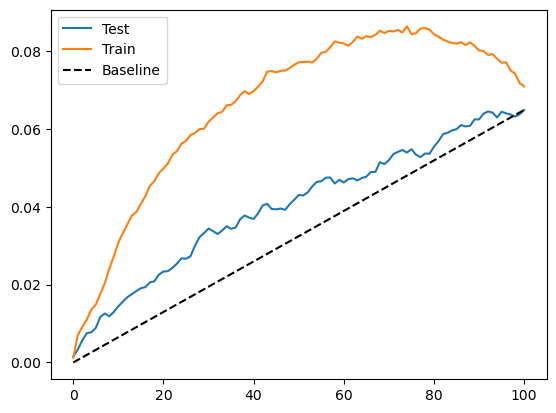

In [146]:
gain_curve_test = cumulative_gain(test_pred, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(train.assign(cate=cate_learner.predict(train[X])), "cate", y="converted", t="em1")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
plt.legend();

正如我们所见，在测试集上，这个即插即用估计器比随机策略要好。然而，它似乎存在严重的过拟合问题，因为训练集上的表现远好于测试集。

这实际上是这种目标变换方法最大的缺点之一。通过这种目标变换，你获得了极大的简便性，只需变换目标就可以使用任何机器学习估计器来预测异质处理效应。然而代价是估计的方差很大。原因在于，这个变换后的目标是个体处理效应的极其嘈杂的估计，噪声会传导到你的估计中。如果样本量不大，这将是一个大问题；但在百万级以上样本量的大数据应用中，这个问题会小一些。


## 连续处理的情况

![img](./images/20/second-estimator.png)

目标变换方法的另一个明显缺点是它只适用于离散或二元的处理。这在因果推断的文献中非常常见：大多数研究都针对二元处理，而很少涉及连续处理。这让我十分困扰，因为在实际行业中，连续处理无处不在，通常表现为需要优化的价格。因此，尽管我找不到关于连续处理的目标变换的任何资料，我还是提出了一个在实践中有效的方法。但请记住，这背后没有非常坚实的计量经济学理论支撑。

为了说明这一点，让我们回到冰淇淋销售的例子。当时我们要做的是估计需求对价格的弹性，从而更好地设置冰淇淋的价格以优化收入。请记得，数据集中的观测单位是一天，我们希望知道什么时候人们对价格上涨不那么敏感。还要记得价格在这个数据集是随机设定的，因此我们不用担心混杂偏差。


In [150]:
prices_rnd = pd.read_csv("./data/ice_cream_sales_rnd.csv")
prices_rnd.head()

,temp,weekday,cost,price,sales
0,25.8,1,0.3,7,230
1,22.7,3,0.5,4,190
2,33.7,7,1.0,5,237
3,23.0,4,0.5,5,193
4,24.4,1,1.0,3,252


和之前一样，先将数据分成训练集和测试集。

In [153]:
np.random.seed(123)
train, test = train_test_split(prices_rnd, test_size=0.3)
train.shape, test.shape

((3500, 5), (1500, 5))

现在我们需要一点创造力。对于离散情况，条件平均处理效应表示在给定单位特征 $X$ 的情况下，从未接受处理到接受处理时结果的变化：

$
\tau(x) = E[Y_i(1) − Y_i(0)|X] = E[\tau_i|X]
$

用通俗的语言说，这就是估计处理对不同单位特征组合的影响，其中特征组合由特征 $X$ 定义。对于连续处理，我们没有这种开关。所有单位都接受了处理，只是强度不同。因此我们不能谈论给予处理与否，而要讨论增加处理的效应。换言之，我们想知道如果将处理量增加一些，结果会怎样变化。这相当于估计结果函数 $Y$ 对处理 $t$ 的偏导数。由于我们希望在每个组别（CATE，而非 ATE）的条件下了解这一点，我们要对特征 $X$ 进行条件：

$
\tau(x) = E[\partial Y_i(t)|X] = E[\tau_i|X]
$

我们如何估计这一点呢？首先考虑简单的情形，即结果对处理是线性的。假设你有两类天气：热天（黄色）和冷天（蓝色）。在冷天，人们对价格上涨更敏感。同时，随着价格上涨，需求呈线性下降。

![img](./images/20/linear-case.png)

在这种情况下，CATE 就是每条需求曲线的斜率。这些斜率告诉我们若价格增加任意金额，需求将下降多少。如果这种关系确实是线性的，我们可以分别在热天和冷天通过简单线性回归的系数来估计这些弹性。

$$
\hat{\tau(x)} = Cov(Y_i, T_i)/Var(T_i) = \dfrac{\sum(Y_i- \bar{Y})(T_i - \bar{T})}{\sum (T_i - \bar{T})^2}
$$

我们可以从这个估计量得到启发，思考如果将它应用到单个单位会怎么样。换句话说，如果我们在每一天都定义类似的东西，它看起来会是这样：


$
Y^*_i = (Y_i- \bar{Y})\dfrac{(T_i - \bar{T})}{\sigma^2_T}
$

通俗地说，就是将原始的目标减去其平均值，再乘以处理变量（同样要减去平均值），最后除以处理的方差。如此一来，我们就得到了连续处理情况下的目标变换。

![img](./images/20/genious.jpeg)

现在的问题是：这真的有效吗？事实上它确实有效，我们可以给出类似二元处理情形的证明。首先，令

$
V_i = \dfrac{(T_i - \bar{T})}{\sigma^2_T}
$

注意 $E[V_i|X_i=x]=0$，因为在随机分配下 $E[T_i|X_i=x]=\bar{T}$，也就是说每个 $X$ 区域都有 $E[T_i]=\bar{T}$。还要注意 $E[T_i V_i | X_i=x]=1$，因为 $E[T_i(T_i - \bar{T})|X_i=x] = E[(T_i - \bar{T})^2|X_i=x]$，这正是处理的方差。最后，在条件独立（随机分配下自然满足）情况下，有 $E[T_i e_i | X_i=x] = E[T_i | X_i=x] E[e_i | X_i=x]$。

为了证明该目标变换有效，我们需要记住，我们要估计的其实是局部线性模型的参数：

$
Y_i = \alpha + \beta T_i + e_i \mid X_i=x
$

在我们的例子中，这些线性模型对应于冷热天的需求曲线。这里我们关注的是 $\beta$ 参数，即条件弹性或 CATE。通过一些推导，我们可以证明：

$
\begin{align}
E[Y^*_i|X_i=x] &= E[(Y_i-\bar{Y})V_i | X_i=x] \\
&= E[(\alpha + \beta T_i + e_i - \bar{Y})V_i | X_i=x] \\
&= \alpha E[V_i | X_i=x] + \beta E[T_i V_i | X_i=x] + E[e_i V_i | X_i=x] \\
&= \beta + E[e_i V_i | X_i=x] \\
&= \beta = \tau(x)
\end{align}
$

请注意，这只适用于随机分配的处理。如果处理不是随机的，我们必须用一个模型 $M(X_i)$ 来估计 $E[T_i|X_i=x]$，用它替代 $\bar{T}$：

$
Y^*_i = (Y_i- \bar{Y})\dfrac{(T_i - M(T_i))}{(T_i - M(T_i))^2}
$

这样可以确保上式推导中第三行的 $\alpha E[V_i | X_i=x]$ 项消失，且 $E[T_i V_i | X_i=x]$ 等于 1。如果你只关心对单位按处理效应排序，而不需要准确的数量，那么不必令 $E[T_i V_i | X_i=x]$ 等于 1；换言之，如果你只想知道在哪些天需求对价格上涨更敏感，而不关心差异有多大，估计的 $\beta$ 是否缩放并不重要。在这种情况下，可以省略分母：

$
Y^*_i = (Y_i- \bar{Y})(T_i - M(T_i))
$

如果这些数学推导让你感到疲惫，不必担心，代码其实很简单。我们再次用上述公式对训练集的目标进行变换。这里处理是随机分配的，因而不需要训练一个预测价格的模型。我也省略了分母，因为此处我只关心对处理效应的排序。


In [157]:
y_star_cont = (train["price"] - train["price"].mean()) * (train["sales"] - train["sales"].mean())

然后，和之前一样，我们用一个机器学习回归模型来预测这个变换后的目标。

In [162]:
cate_learner = LGBMRegressor(max_depth=3, min_child_samples=300, num_leaves=5)

np.random.seed(123)
cate_learner.fit(train[["temp", "weekday", "cost"]], y_star_cont)

cate_test_transf_y = cate_learner.predict(test[["temp", "weekday", "cost"]])

test_pred = test.assign(cate=cate_test_transf_y)
test_pred.sample(5)

,temp,weekday,cost,price,sales,cate
2815,15.7,4,1.5,3,187,-3.536723
257,29.4,3,1.0,3,209,8.334653
2585,24.6,6,1.0,10,197,5.628261
3260,20.2,1,0.5,4,246,-45.753226
1999,10.0,4,0.5,10,139,-7.794578


这一次，CATE 的解释不太直观。由于在目标变换中去掉了分母，所看到的 CATE 被 $Var(X)$ 缩放了。然而，这样的预测仍然可以很好地对处理效应进行排序。为了验证这一点，我们可以像之前一样使用累积增益曲线。

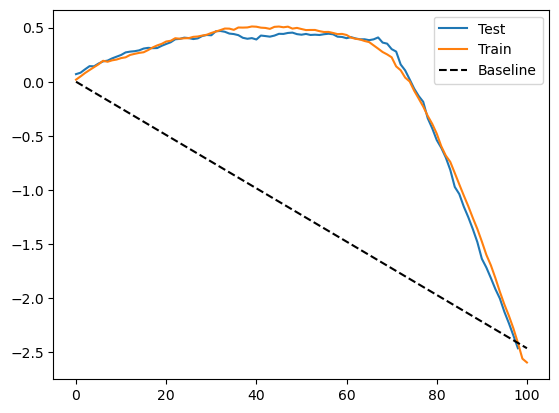

In [165]:
gain_curve_test = cumulative_gain(test.assign(cate=cate_test_transf_y),
                                "cate", y="sales", t="price")

gain_curve_train = cumulative_gain(train.assign(cate=cate_learner.predict(train[["temp", "weekday", "cost"]])),
                                   "cate", y="sales", t="price")


plt.plot(gain_curve_test, label="Test")
plt.plot(gain_curve_train, label="Train")
plt.plot([0, 100], [0, elast(test, "sales", "price")], linestyle="--", color="black", label="Baseline")
plt.legend();

对于这份数据，使用变换后的目标的模型明显优于随机策略。此外，训练集和测试集的结果也比较接近，因此方差不是问题。这只是该数据集的特性；还记得在二元处理情形下情况并非如此，当时模型的表现并不理想。

### 非线性处理效应

说完了连续处理的情况，还有一个问题需要解决。我们假定处理效应是线性的，但这种假设往往不合理，处理效应通常会以某种形式呈现饱和。在我们的例子中，可以合理地认为需求在初始涨价时下降更快，随后下降速度减缓。

![img](./images/20/non-linear-case.png)

问题在于**弹性或处理效应会随处理水平而变化**。在我们的例子中，曲线开始阶段的处理效应更强，而随着价格升高，效应减小。假设你有两种天气：热天（黄色）和冷天（蓝色），我们希望通过因果模型区分它们。但在非线性情况下，如果我们在曲线的不同价格点观察，热天和冷天的弹性可能相同（见右图），这使得因果模型难以区分它们。

这个问题没有简单的解决办法，我必须承认仍在探索最优的方法。目前的做法是思考处理效应的函数形式，尝试使其线性化。例如，需求通常具有以下形式，其中更大的 $\alpha$ 表示价格每提高一个单位，需求下降得更快：

$
D_i = \dfrac{1}{P_i^{\alpha}}
$

因此，如果对需求 $Y$ 和价格 $T$ 同时做对数变换，就会得到近似线性的关系：

$
\begin{align}
\log(D)_i &= \log\bigg(\dfrac{1}{P_i^{\alpha}}\bigg) \\
&= \log(1) - \log(P_i^{\alpha}) \\
&= \log(1) - \log(P_i^{\alpha}) \\
&= - \alpha * \log(P_i) \\
\end{align}
$

线性化并不容易，需要仔细思考。但你也可以尝试不同的变换，看看哪种效果最好。通常，对数或平方根等变换会有帮助。

## 关键观点

我们正在迈向使用机器学习模型来估计条件平均处理效应。最大的挑战是如何将预测模型改造成估计因果效应的模型。换个角度看，预测模型关注的是估计结果 $Y$ 作为特征 $X$ 以及可能的处理 $T$ 的函数 $Y = M(X,T)$，而因果模型需要估计该函数对处理的偏导数 $\partial Y = \partial M(X,T)$。这并不容易，因为虽然我们能观察到结果 $Y$，却无法在个体层面观察到 $\partial Y$。因此在设计模型的目标函数时必须很有创造性。

这里我们看到了一个非常简单的目标变换技巧。其思想是将原始目标 $Y$ 与处理 $T$ 组合起来，形成一个在期望上等于 CATE 的变换后的目标。有了这个新目标，就可以将任何预测型机器学习模型用来估计它，模型输出的便是 CATE 的估计。顺便提一下，除了目标变换，这种方法也被称为 **F-Learner**。

然而这种简单性也有代价。变换后的目标是个体处理效应的一个噪声很大的估计，这种噪声会以方差形式传导到模型的估计中。因此，目标变换更适用于大数据场景，在大样本下方差问题较小。目标变换的另一个缺点是它只适用于二元或类别型处理。我们已经尽力提出了一个连续处理版本，并且似乎有效，但目前仍缺乏坚实的理论框架来支持它。

最后，我们讨论了非线性处理效应及其带来的挑战。当处理效应随处理水平而变化时，我们可能误以为不同个体具有相同的反应曲线，只是因为它们对处理的敏感度相同，而实际上它们接受的处理强度不同。

## 参考说明

本章内容主要基于作者个人的经验总结，许多观点和方法源自实践中的体会。因此，无法提供严格意义上的学术参考文献。与正规科研工作不同，这些内容没有经过系统性的学术审查，也未经过同行评议与理论论证。读者或许会注意到，本文更多讨论的是“实践中有效的方法”，而非详细阐述其背后的理论基础。这种方法可以被视为“来自一线的经验科学”（a sort of science from the streets）。尽管如此，既然这些内容已公开发布，也非常欢迎批评与反馈——如果读者发现其中有明显错误或不妥之处，欢迎提出 issue，作者会尽力回应。

最后，对于那些希望系统学习机器学习的读者，作者也意识到本章的讲解可能过于简略。坦率地说，作者认为自己真正能够贡献价值的领域是因果推断的教学，而非机器学习。机器学习领域已有大量优质的公开资源，远超作者所能提供的内容。其中的经典之作，就是 [Andrew Ng 的机器学习课程](https://www.coursera.org/learn/machine-learning)，如果读者是机器学习初学者，作者强烈推荐认真学习这门课程。


## 参与贡献

**《Causal Inference for the Brave and True》** 是一本关于因果推断的开源教材，致力于以经济上可负担、认知上可理解的方式，普及这门“科学的统计基础”。全书基于 Python，仅使用自由开源软件编写，原始英文版本由 [Matheus Facure](https://github.com/matheusfacure) 编写与维护。

本书的中文版由黄文喆与许文立助理教授合作翻译，并托管在 [GitHub 中文主页](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。希望本地化的内容能帮助更多中文读者学习和掌握因果推断方法。

如果你觉得这本书对你有帮助，并希望支持该项目，可以前往 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true) 支持原作者。

如果你暂时不方便进行经济支持，也可以通过以下方式参与贡献：

* 修正错别字
* 提出翻译或表达建议
* 反馈你未能理解的部分内容

欢迎前往英文版或中文版仓库点击 [issues 区](https://github.com/matheusfacure/python-causality-handbook/issues) 或 [中文版 issues 区](https://github.com/Wenzhe-Huang/python-causality-handbook-zh/issues) 提出反馈。

最后，如果你喜欢这本书的内容，也请将其分享给可能感兴趣的朋友，并为项目在 GitHub 上点亮一颗星：[英文版仓库](https://github.com/matheusfacure/python-causality-handbook) / [中文版仓库](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。